# DATA 620
### Final Project - Natural Language Processing and Social Network Analysis Combined
### Steven Ellingson

I've gotten this far just doing movies, so I decided to keep going with it. Once again, I took from
https://www.kaggle.com/rounakbanik/the-movies-dataset, and once again I pulled in movie scripts from www.imsdb.com. 


The big difference is with this project is that I parsing through the scripts to find characters.  Before I was just doing document classification on the whole dataset. I pulled in the script, and using a combination of techniques, separated out the character names along with their dialogue. This worked very well.  I attempted to match them to the dataset in order to assign gender.  This proved to be a daunting task, and while I ended up with an ok dataset, this took so much time it kept me from doing all of the analysis that I was hoping to do.


In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector as dbc
import re
import warnings
import os
import string

import requests
import urllib.request
import time
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import pickle

import nltk
from nltk.corpus import names

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

seed = 4312
from xgboost import plot_importance
from matplotlib import pyplot as plt
import networkx as nx
import networkx.algorithms.bipartite as bipartite
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')
db = dbc.connect(
    database='movies',
    host='127.0.0.1',
    user='root',
    passwd='soaren'
)

I will start by pulling my movie/genre list. I will pull any movie that I think has a chance of being on this list - this should only be English-speaking feature-films.  I'm pulling some extra info for the ones that come up with more than one result.

In [4]:
SQL = """
select 
m.id,
m.title,
m.release_date,
m.tagline,
group_concat(distinct g.name order by g.name) as genre_list,
m.vote_count,
m.budget,
group_concat(distinct case when mc.job like '%writer%' or mc.job like '%screenplay%' then c.name end) as writers
from movies m 
left join movie_genres mg on m.id= mg.movie_id
left join genres g on mg.genre_id = g.id
left join movie_crew mc on m.id = mc.movie_id
left join crew c on mc.crew_id = c.id
where original_language = 'en'
	and vote_count >= 10
	and status = 'Released'
	and runtime >= 60
group by m.id
"""

movies = pd.read_sql(SQL,db)
movies.set_index('id',inplace=True, drop=False)
movies.head(10)

,id,title,release_date,tagline,genre_list,vote_count,budget,writers
id,,,,,,,,
5,5,Four Rooms,1995-12-09,Twelve outrageous guests. Four scandalous requ...,"Comedy,Crime",539,4000000.0,"Alexandre Rockwell,Allison Anders,Quentin Tara..."
6,6,Judgment Night,1993-10-15,Don't move. Don't whisper. Don't even breathe.,"Action,Crime,Thriller",79,0.0,Lewis Colick
11,11,Star Wars,1977-05-25,"A long time ago in a galaxy far, far away...","Action,Adventure,Science Fiction",6778,11000000.0,George Lucas
12,12,Finding Nemo,2003-05-30,There are 3.7 trillion fish in the ocean. They...,"Animation,Family",6292,94000000.0,"Andrew Stanton,Bob Peterson,David Reynolds"
13,13,Forrest Gump,1994-07-06,"The world will never be the same, once you've ...","Comedy,Drama,Romance",8147,55000000.0,Eric Roth
14,14,American Beauty,1999-09-15,Look closer.,Drama,3438,15000000.0,Alan Ball
15,15,Citizen Kane,1941-04-30,It's Terrific!,"Drama,Mystery",1244,839727.0,"Herman J. Mankiewicz,John Houseman,Mollie Kent..."
16,16,Dancer in the Dark,2000-05-17,You don't need eyes to see.,"Crime,Drama,Music",392,12800000.0,Lars von Trier
17,17,The Dark,2006-01-26,One of the living for one of the dead.,"Horror,Mystery,Thriller",76,0.0,Stephen Massicotte


OK, now I will get the list of scripts from imsdb. They are all listed on one page, so I can scrape that and turn it into a data frame.


In [9]:
url = 'https://www.imsdb.com/all%20scripts/'
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

This next part will match scripts with the movie title in the movies database.  This is all a repeate of assignment 6 so I won't add too much description here.

In [61]:
scripts = pd.DataFrame([[x.contents[0].contents[0],x.contents[0]['href'], x.contents[1], x.contents[3].contents[0].replace('Written by ','')] for x in soup.findAll('p')], columns = ['title', 'link','script_date', 'writers'])

def clean_series(s):
    s = s.str.split('(').str[0].str.strip()
    s = s.str.replace(r'^(.+), (A|The)$',r'\2 \1',regex=True)
    s = s.str.replace(r'[^a-zA-Z\d ]','',regex=True)
    return(s.str.lower())

scripts['title_clean'] = clean_series(scripts['title'])
movies['title_clean'] = clean_series(movies['title'])
    
#Initialize a few things
mismatches = None
missing = None
scripts['movie_id']=np.nan

mismatch_count = 0
missing_count = 0
found_count = 0
temp_count = 0
#Loop through and match them up!
for key,row in scripts.iterrows():
    matches = movies[movies.title_clean==row['title_clean']]
    matches['fuzz'] = 0
    matches['script_id'] = key
    matches['script_title'] = row['title']
    matches['script_date'] = row['script_date']
    matches['script_writers'] = row['writers']
    
    if(len(matches)==1):
        found_count = found_count + 1
        scripts.loc[key, 'movie_id'] = matches.index[0]
    else:
        if(len(matches)==0):
            missing_count = missing_count+1
            #Try a fuzzy match. Copy the whole movies dataframe, check the fuzzy match and sort.
            temp_df = movies.copy()
            
            temp_df['fuzz'] = temp_df['title_clean'].apply(lambda x: fuzz.ratio(x, row['title_clean']))
            
            matches = temp_df.sort_values('fuzz', ascending=False).head(3)
            matches['script_id'] = key
            matches['script_title'] = row['title']
            matches['script_date'] = row['script_date']
            matches['script_writers'] = row['writers']
            
            if(missing is None):
                missing = pd.DataFrame(row).T
            else:
                missing = missing.append(row)
        else:
            mismatch_count = mismatch_count+1
                
        if(mismatches is None):
            mismatches = matches.copy()
        else:
            mismatches = mismatches.append(matches, ignore_index=True)

    temp_count=temp_count + 1
    if (temp_count >=100):
        temp_count=0
        print (str(found_count) + ' found, ' + str(missing_count) + ' missing, ' + str(mismatch_count) + ' mismatched.')
        
script_fix = {2:18164,37:11379,44:2665,47:348,48:8077,50:395,55:25430,58:12142,72:68895,75:814,82:9444,85:96724,94:24913,103:49012,107:18355,110:816,111:817,115:9320,116:24428,123:165,126:9737,140:268,142:415,153:321612,161:39437,184:11622,186:96936,196:619,198:9586,202:22821,205:9303,207:2501,223:9208,234:9894,237:7340,261:411,282:37430,295:884,301:263341,307:11386,321:923,322:8408,324:828,329:34803,332:13018,343:1813,359:64690,370:11374,391:765,399:754,400:38363,402:9738,419:3604,424:9093,435:4488,437:58151,438:11797,441:44363,442:109445,445:5503,448:228150,459:1485,464:5916,470:620,471:2978,475:9504,477:238,478:240,481:929,495:64682,500:9434,517:11282,523:671,524:11618,531:11088,534:11253,536:11569,547:9792,571:43947,584:87,596:23378,602:1635,613:38684,637:393,637:24,640:254,654:5516,669:11976,672:82695,676:14372,678:6522,700:120,701:122,702:121,709:14736,719:9313,720:9509,723:574,725:14462,737:854,745:19403,758:9822,787:564,811:377,812:10131,826:161,829:2623,830:11234,845:274870,847:2024,864:285,867:871,871:1089,872:36897,881:38321,884:30197,885:18133,886:36599,890:539,902:1369,905:567,918:281957,926:5548,931:454,938:96721,944:10003,945:11468,946:11528,951:111,960:116745,962:4584,977:10528,988:274,1030:11,1031:1894,1032:1892,1033:1895,1034:1891,1036:1893,1048:42160,1050:16723,1051:599,1076:218,1077:280,1094:10057,1099:2135,1102:49517,1103:597,1109:861,1115:1857,1117:9044,1122:44264,1126:8966,1127:18239,1137:48138,1138:14160,1150:12473,1153:11358,1157:8909,1169:10053,1189:13446,1194:297762,1208:30548}
for key,val in script_fix.items():
    if(pd.isnull(scripts.loc[key,'movie_id'])):
        scripts.loc[key,'movie_id']=val
    else:
        print(str(key) + ',' + str(val) + ':' + "Trying to update a non-null value, you may be doing something wrong!")
        break

scripts.index.name = None
scripts = scripts.merge(movies[['id','genre_list']], how='left',left_on = 'movie_id', right_index = True)
scripts.dropna(inplace = True, subset=['genre_list'])
scripts['movie_id'] = scripts['movie_id'].astype(int)
scripts.drop('id', axis = 1, inplace = True)
scripts.head()
len(scripts)

74 found, 20 missing, 6 mismatched.
150 found, 35 missing, 15 mismatched.
233 found, 45 missing, 22 mismatched.
316 found, 56 missing, 28 mismatched.
394 found, 62 missing, 44 mismatched.
479 found, 71 missing, 50 mismatched.
560 found, 83 missing, 57 mismatched.
645 found, 91 missing, 64 mismatched.
720 found, 106 missing, 74 mismatched.
799 found, 117 missing, 84 mismatched.
878 found, 135 missing, 87 mismatched.
955 found, 146 missing, 99 mismatched.


1126

Here are a couple of recursive functions I will use to make sure we get on the right level when parsing the script. It will retain the tag, which should help to sort out dialogue vs. setting vs. character.

In [7]:
def get_script_text(text):
    text2 = text.findNext('pre')
    if text2 is None:
        return(text)
    else:
        return(get_script_text(text2))

def get_child_text(child, label):
    if (child.name is None):
        if(str(child.strip())):
            return([label, str(child.strip())])
        else:
            return(None)
    else:
        label = child.name
        for child2 in child.children:
            return(get_child_text(child2, label))

OK so now we need to loop through and actually pull the script. I will be using "BeautifulSoup".
I will be creating a dictionary, which will have a list of lists inside of each entry.
Each of the lists will be a line, and it's corresponding tag.  "None" should be dialogue, "b" should be characters and setting.

In [ ]:
i = 0
j = 0
script_dict=dict()

for key, row in scripts.iterrows():

    # Pull up the summary page which will get us the actual link to the script text
    summary_url = 'https://www.imsdb.com' + row['link']
    summary_response = requests.get(summary_url)
    summary_soup = BeautifulSoup(summary_response.text, "html.parser")
    for a in summary_soup.findAll('a', href=True):

        if ("/scripts/" in a['href']) and (".html" in a['href']) and ('Read' in a.contents[0]):

            # Now we're on the script page - let's grab the script text
            response = requests.get('https://www.imsdb.com' + a['href'])
            soup = BeautifulSoup(response.text, "html.parser")

            scrtext = get_script_text(soup.findAll("td", {"class": "scrtext"})[0])


            script_text = []
            for child in scrtext.children:
                line = get_child_text(child, 'None')
                if line is not None:
                    script_text.append(line)
            script_dict[key] = script_text

    i = i + 1
    j = j + 1
    if (j > 50):
        print(row['title'] + ':' + str(i) + ' Done!')
        j = 0

The above took a long time, so save the objects using pickle so we can start from here if need be.

In [ ]:
#pickle.dump(script_dict, open( "movie_script_dictionary.p", "wb" ))

In [62]:
script_dict = pickle.load(open( "movie_script_dictionary.p", "rb" ))

Remove any scripts that were missing. Then we'll loop through and create a dataframe of all of the lines of the movies.

In [64]:
for i in list(script_dict.keys()):
    row = script_dict[i]
    if(len(row)<100):
        script_dict.pop(i)
scripts = scripts.loc[scripts.index.isin(script_dict.keys())]
print('script dict: ',str(len(script_dict)),', scripts df:',str(len(scripts)))

script dict:  1011 , scripts df: 1011


In [65]:
line_list = []
for id,l in script_dict.items():
    line_list.extend([[id,i,l[i][0],l[i][1]] for i in range(len(l))])
    
line_df = pd.DataFrame(line_list, columns = ['id','line','type','text'])
line_df.text = line_df.text.str.replace(r'[^a-zA-Z\d :\,\.\-\\\'\(\)]', '', regex=True).str.replace('    ', ' ').str.replace('   ', ' ').str.replace('  ', ' ').str.strip().str.lower()

Now Let's grab just the "b" tagged lines, which is where the character names should be.

In [66]:
b_df = line_df[line_df['type']=='b']
b_df.head(20)

,id,line,type,text
0,0,0,b,ten things i hate about you
4,0,4,b,padua high school - day
6,0,6,b,padua high parking lot - day
10,0,10,b,rider
13,0,13,b,kat
18,0,18,b,int. girls' room - day
20,0,20,b,bianca
22,0,22,b,chastity
24,0,24,b,bianca
27,0,27,b,hallway - day- continuous


Next we will build a model for sorting out actual character names from settings/directions, etc.  In order to do that I will pull a random sample and hand label them as a character or not.  Then I'll pull them back in.

In [67]:
rnd = np.random.RandomState(123)
label_sample = np.unique(rnd.choice(b_df['text'], size = 10000))

In [68]:
np.savetxt('name_labeling.txt', label_sample, fmt = '%s')

In [69]:
labeled_characters = pd.read_csv('character_labelled.csv', na_filter=False)

Now we'll create features for the model.  We'll start with frequency of the text in this and other movies.

In [70]:
character_df = b_df[['id','text','type']].groupby(['id','text'], as_index=False).count()
character_df.columns = ['id','text','count']
temp_df = character_df[['text','count']].groupby(['text'], as_index=False).agg(['count','sum'])
temp_df.columns = ['movies','total_count']
character_df = character_df.merge(temp_df,how='left',left_on='text',right_index=True)
temp_df = None
character_df.head()

,id,text,count,movies,total_count
0,0,(0. s.),2,1,2
1,0,--,1,47,232
2,0,across the courtyard,1,3,3
3,0,across the room,4,13,21
4,0,another angle,1,72,498


I found quite a few things that looked like good features while labeling. Mostly I'm looking for specific words or pieces of text that seemed to be more likely on one side or the other.

In [71]:
character_df['rel_freq'] = character_df['count']/character_df['total_count']
character_df['avg_freq'] = character_df['total_count']/character_df['movies']
character_df['letters'] = character_df['text'].str.len()
character_df['count_space'] = character_df['text'].str.count(' ')
character_df['count_colon'] = character_df['text'].str.count('\:')
character_df['count_comma'] = character_df['text'].str.count('\,')
character_df['count_period'] = character_df['text'].str.count('\.')
character_df['count_dash'] = character_df['text'].str.count('\-')
character_df['count_l_paren'] = character_df['text'].str.count('\(')
character_df['count_r_paren'] = character_df['text'].str.count('\)')
character_df['count_day'] = character_df['text'].str.count('day')
character_df['count_night'] = character_df['text'].str.count('night')
character_df['count_cont'] = character_df['text'].str.count(r'([^a-z]|^)cont(\'d|inuing|inued|d|\)|$)')
character_df['letters_non_paren'] = character_df['text'].str.split('(').str[0].str.len()
character_df['count_os'] = character_df['text'].str.count(r'([^a-z]|^)o\.?s\.?([^a-z]|$)')
character_df['count_vo'] = character_df['text'].str.count(r'([^a-z]|^)v\.?o\.?([^a-z]|$)')
character_df['count_voice'] = character_df['text'].str.count('voice')
character_df['count_and'] = character_df['text'].str.count(' and ')
character_df['count_angle'] = character_df['text'].str.count(r'([^a-z]|^)angle([^a-z]|$)')
character_df['count_pov'] = character_df['text'].str.count(r'([^a-z]|^)p\.?o\.?v\.?([^a-z]|$)')
character_df['count_shot'] = character_df['text'].str.count(r'([^a-z]|^)shot([^a-z]|$)')
character_df['count_title'] = character_df['text'].str.count(r'([^a-z]|^)(mister|mr|miss|misses|missus|mrs|ms|miss|sir|sire|madam|ma\'am|lord|lady|esq|dr|doctor|professor|principal|chancellor|reverend|pastor|rabbi|nurse)([^a-z]|$)')
character_df['count_suffix'] = character_df['text'].str.count(r'([^a-z]|^)(junior|senior|jr|sr|esq)([^a-z]|$)')

Now we'll take a look at the part-of-speech patterns present in the labeled dataset. We'll start by grouping them and exploring a bit before deciding on a list a features.

In [72]:
def tokenize(text):
    text = nltk.word_tokenize(text)
    text = nltk.pos_tag(text)
    text = [t for t in text if t[0] not in string.punctuation]
    return(text)
def pos_pattern(tokens):
    return('|'.join([t[1] for t in tokens]))

In [73]:
labeled_characters['pattern'] = labeled_characters['text'].apply(lambda x: pos_pattern(tokenize(x)))

In [74]:
patterns = labeled_characters[['pattern','character']].groupby('pattern').agg(['count','mean'])
patterns.columns = ['count','mean']
patterns.sort_values('count', ascending=False).head(30)

,count,mean
pattern,,
NN,2101,0.949548
NN|NN,357,0.845938
CD,203,0.009852
NN|JJ|MD,167,1.000000
NNS,130,0.846154
JJ|NN,104,0.740385
NN|NN|NN,82,0.158537
NN|FW,76,1.000000
NN|NN|NN|NN,70,0.000000


Some really interesting patterns here, some of them perfectly predict (either 100% or 0%) for the labeled data. Let's take a look at a few to see what types of text these represent.

In [75]:
labeled_characters[labeled_characters['pattern']=='NN|JJ|MD'].head(10)

,text,character,pattern
933,ackerman (cont'd),1,NN|JJ|MD
937,adam (cont'd),1,NN|JJ|MD
973,alan (cont'd),1,NN|JJ|MD
979,albert (cont'd),1,NN|JJ|MD
983,alejandro (cont'd),1,NN|JJ|MD
995,ali (cont'd),1,NN|JJ|MD
1042,angela (cont'd),1,NN|JJ|MD
1046,angier (cont'd),1,NN|JJ|MD
1083,anna (cont'd),1,NN|JJ|MD
1114,arlington (cont'd),1,NN|JJ|MD


So "MD" is just all the (cont'd) characters. I think this is mislabeled since it isn't a standard contraction.

In [76]:
labeled_characters[labeled_characters['pattern']=='NN|NN|NN|NN'].head(10)

,text,character,pattern
2178,"ext. airlock, space station",0,NN|NN|NN|NN
2194,ext. beach house - day,0,NN|NN|NN|NN
2196,ext. beach restaurant - night,0,NN|NN|NN|NN
2219,ext. cider house - day,0,NN|NN|NN|NN
2223,ext. city street - night,0,NN|NN|NN|NN
2226,ext. clutter farm - sunset,0,NN|NN|NN|NN
2234,ext. county road - day,0,NN|NN|NN|NN
2245,ext. desert motel - night,0,NN|NN|NN|NN
2248,ext. e.s.u. campus - morning,0,NN|NN|NN|NN
2254,ext. ernswiler house - day,0,NN|NN|NN|NN


Makes perfect sense - 4 nouns is basically a list of attributes about a place. This partially works because the tagger decides that int. and ext. are nouns

In [77]:
labeled_characters[labeled_characters['pattern']=='NN|CD'].head(10)

,text,character,pattern
952,agent 1,1,NN|CD
1174,b22 01.00,0,NN|CD
1282,biker 1,1,NN|CD
1350,bomb 20,0,NN|CD
1373,boy 1,1,NN|CD
1374,boy 2,1,NN|CD
1457,caine 607,1,NN|CD
1482,card 1:,0,NN|CD
1623,clerk 2,1,NN|CD
1746,cop 1,1,NN|CD


This is one I expected to be a perfect pattern for characters - i/e (officer 3).  But clearly there is some other stuff in there like (scene 19).

Let's look at the individual pos tags and see if their presence is predictive.

In [78]:
pos = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
pos_list = []
for p in pos:
    pattern = re.compile('(\||^)' + p + '(\||$)')
    pos_list.append([p,
    labeled_characters[(labeled_characters['pattern'].str.count(pattern)>0)]['character'].mean(),
    len(labeled_characters[(labeled_characters['pattern'].str.count(pattern)>0)]['character'])
    ])
pos_df = pd.DataFrame(pos_list, columns = ['pos','mean','count'])
pos_df.sort_values('mean', inplace=True)
pos_df = pos_df[pos_df['count']>=5]
pos_df

,pos,mean,count
0,CC,0.000000,97
22,RP,0.000000,35
20,RBR,0.000000,5
32,WP,0.000000,7
23,TO,0.009709,103
30,VBZ,0.022727,88
25,VB,0.046980,149
1,CD,0.066351,844
5,IN,0.069588,388
2,DT,0.073370,368


At the top, there are quite a few strong indicators of non-character. Past/present verbs are likely not characters. Digits, prepositions conjunctions, and other sentence words as well.

Not as strong at the bottom - since Nouns could be characters or places, objects, etc. The two that show up strongly - foreign words and modal are likely tagging mistakes.

In [79]:
labeled_characters[(labeled_characters['pattern'].str.count('MD')>0)].head(10)

,text,character,pattern
5,'the mother daughter diamonds...',0,MD|RB|VB|NNS|:
36,(cont'd),0,VB|MD
933,ackerman (cont'd),1,NN|JJ|MD
937,adam (cont'd),1,NN|JJ|MD
973,alan (cont'd),1,NN|JJ|MD
979,albert (cont'd),1,NN|JJ|MD
983,alejandro (cont'd),1,NN|JJ|MD
990,alfred hitchcock (cont'd),1,VBN|NN|JJ|MD
995,ali (cont'd),1,NN|JJ|MD
1038,andy warhol (cont'd),1,JJ|NN|JJ|MD


In [80]:
labeled_characters[(labeled_characters['pattern'].str.count('FW')>0)].head(10)

,text,character,pattern
412,198(new). i n t . m e n ' s r o o m - n i g h t,0,CD|JJ|JJ|JJ|NN|NN|NN|NN|JJ|NN|NN|IN|FW|NN|NN|V...
925,abigail (v.0.),1,NN|FW
931,ace (v.o.),1,NN|FW
948,adult pi (v.o.),1,NN|NN|FW
961,agu (v.o.),1,NN|FW
965,aibileen (v.o.),1,NN|FW
971,al (v.o.),1,NN|FW
1010,alvin (v.o.),1,NN|FW
1037,andy (v.o.),1,NN|FW
1089,annie (v.o.),1,NN|FW


Yes - it's just interpreting v.o. (voiceover) as a foreign word, and 'cont'd (continued) as a modal verb for some reason.

I'll go ahead and create features for all patterns that show up at least 10 times, and pos tags that show up at least 5 times. 

In [81]:
character_df['pattern'] = character_df['text'].apply(lambda x: pos_pattern(tokenize(x)))
for p in patterns[patterns['count']>10].index:
    col_name = 'pattern_' + p
    character_df[col_name]=0
    character_df.loc[character_df['pattern']==p, col_name]=1

for i,row in pos_df.iterrows():
    p = row['pos']
    pattern = re.compile('(\||^)' + p + '(\||$)')
    col_name = 'pos_' + p
    character_df[col_name] = character_df['pattern'].str.count(pattern)
character_df.head(20)

,id,text,count,movies,total_count,rel_freq,avg_freq,letters,count_space,count_colon,...,pos_RB,pos_VBP,pos_JJ,pos_NNS,pos_PRP,pos_NN,pos_UH,pos_PRP$,pos_MD,pos_FW
0,0,(0. s.),2,1,2,1.000000,2.000000,7,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,--,1,47,232,0.004310,4.936170,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,across the courtyard,1,3,3,0.333333,1.000000,20,2,0,...,0,0,0,0,0,1,0,0,0,0
3,0,across the room,4,13,21,0.190476,1.615385,15,2,0,...,0,0,0,0,0,1,0,0,0,0
4,0,another angle,1,72,498,0.002008,6.916667,13,1,0,...,0,0,0,0,0,1,0,0,0,0
5,0,at the bar,1,11,16,0.062500,1.454545,10,2,0,...,0,0,0,0,0,1,0,0,0,0
6,0,back to kat and mandella,1,1,1,1.000000,1.000000,24,4,0,...,1,0,0,0,0,0,0,0,0,0
7,0,bartender,2,99,301,0.006645,3.040404,9,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,bianca,134,4,183,0.732240,45.750000,6,0,0,...,0,0,0,0,0,1,0,0,0,0
9,0,bianca and walter,1,1,1,1.000000,1.000000,17,2,0,...,0,0,0,0,0,2,0,0,0,0


I'll also pull in the nltk name list and add a feature indicating if one of those names is somewhere in the text.

In [82]:
name_list = names.words('male.txt')
name_list.extend(names.words('female.txt'))
name_list = [n.lower() for n in name_list]
name_list = list(set(name_list))

In [83]:
def in_name_list(text):
    tokens = nltk.word_tokenize(text)
    result = 0
    for t in tokens:
        if t in name_list:
            result = 1
            break
    return(result)

In [84]:
character_df['has_name'] = character_df['text'].apply(lambda x: in_name_list(x))

In [85]:
character_df_model = character_df.merge(labeled_characters[['text','character']],
                                        how='inner', left_on='text', right_on='text')
character_df_model = character_df_model.sample(frac=1).drop_duplicates(subset=['text'])
character_df.to_csv('full_character_dataframe.csv')
character_df_model.to_csv('modeling_character_dataframe.csv')
character_df.head(10)

,id,text,count,movies,total_count,rel_freq,avg_freq,letters,count_space,count_colon,...,pos_VBP,pos_JJ,pos_NNS,pos_PRP,pos_NN,pos_UH,pos_PRP$,pos_MD,pos_FW,has_name
0,0,(0. s.),2,1,2,1.000000,2.000000,7,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,--,1,47,232,0.004310,4.936170,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,across the courtyard,1,3,3,0.333333,1.000000,20,2,0,...,0,0,0,0,1,0,0,0,0,0
3,0,across the room,4,13,21,0.190476,1.615385,15,2,0,...,0,0,0,0,1,0,0,0,0,0
4,0,another angle,1,72,498,0.002008,6.916667,13,1,0,...,0,0,0,0,1,0,0,0,0,0
5,0,at the bar,1,11,16,0.062500,1.454545,10,2,0,...,0,0,0,0,1,0,0,0,0,0
6,0,back to kat and mandella,1,1,1,1.000000,1.000000,24,4,0,...,0,0,0,0,0,0,0,0,0,1
7,0,bartender,2,99,301,0.006645,3.040404,9,0,0,...,0,0,0,0,1,0,0,0,0,0
8,0,bianca,134,4,183,0.732240,45.750000,6,0,0,...,0,0,0,0,1,0,0,0,0,1
9,0,bianca and walter,1,1,1,1.000000,1.000000,17,2,0,...,0,0,0,0,2,0,0,0,0,1


In [86]:
train, test = train_test_split(character_df_model, test_size=0.2, random_state=seed)

X_train = train.drop(['text','pattern','character', 'id'], axis=1)
y_train = train['character']
X_test = test.drop(['text','pattern','character', 'id'], axis=1)
y_test = test['character']

In [87]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state = seed)
param_dist = {'n_estimators': stats.randint(5, 1000),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
xg = RandomizedSearchCV(xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)
xg.fit(X_train, y_train)
xg.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.6min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.528287731540506, gamma=0,
              learning_rate=0.049690153263003696, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=452, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=4312,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9348160925220164, verbosity=1)

In [88]:
print ("Training Accuracy: " + str(round(100*sum(y_train== xg.predict(X_train))/len(y_train),1)) + '%')
print("Test Accuracy: " + str(round(100*sum(y_test== xg.predict(X_test))/len(y_test),1)) + '%')

Training Accuracy: 98.7%
Test Accuracy: 97.4%


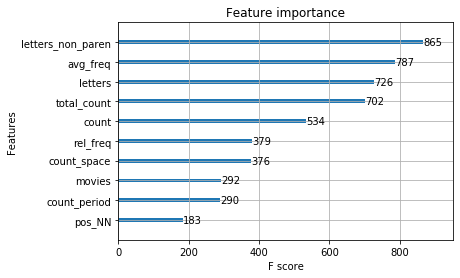

In [89]:
plot_importance(xg.best_estimator_,max_num_features=10)
plt.show()

Looks pretty good, with a 97% accuracy on the test set.
Let's look at the ones it got wrong.

In [90]:
pd.set_option('display.max_rows', 500)
test.loc[y_test!= xg.predict(X_test),['text','character']].sort_values('character')

,text,character
67031,shadowy colonnade,0
67171,wipe to,0
64110,rham jas,0
65292,cereal,0
65252,subtitles),0
67447,on deborah...,0
58487,pov,0
65923,another pov,0
62880,british delegate,0
42804,b20,0


In [91]:
test['pred'] = xg.predict_proba(X_test)[:,1]
test['pred_round'] = np.floor(test['pred']*10)
test.head()

test[['pred_round','character']].groupby('pred_round').agg(['count','mean'])


character          
               count      mean
pred_round                    
0.0              442  0.000000
1.0               17  0.117647
2.0               12  0.000000
3.0               11  0.454545
4.0                8  0.375000
5.0               11  0.545455
6.0                8  0.750000
7.0                8  0.875000
8.0               31  0.870968
9.0              599  0.986644

In [92]:
character_df['character_predict'] = xg.predict_proba(character_df.drop(['text','pattern','id'], axis=1))[:,1]

Here are some the model feels strongly as characters.

In [93]:
print(list(character_df[character_df['character_predict']>0.9]['text'].head(50)))

['bartender', 'bianca', 'boy', 'boy (0.s.)', 'bruce', 'cameron', 'cameron (0. s.)', 'chastity', 'clem', 'cowboy', 'derek', 'girl', 'god', 'guy', 'his pov', 'jock', 'joey', 'kat', 'kat (0. s.)', 'kid', 'mandella', 'michael', 'miss perky', 'mr. chapin', 'mrs. blaise', 'patrick', 'pepe', 'rider', 'sharon', 'teacher', 'teacher (0.s.)', 'trevor', 'walter', 'ashley', 'baby', 'coach', 'coach (v.o.)', 'debbie', 'doctor', 'gabe', 'grace', 'gus', 'gus (from below)', 'gus (o.s.)', 'haley', 'jacob', 'jacob (o.s.)', 'jeff', 'jim', 'keith']


Here are some it feels strongly are not characters.

In [94]:
print(list(character_df[character_df['character_predict']<0.1]['text'].head(50)))

['(0. s.)', '--', 'across the courtyard', 'across the room', 'at the bar', 'back to kat and mandella', 'bianca and walter', "bianca's room - day", "bogey lowenstein's house - night", "bogey's kitchen - night", 'cafeteria - day', "cameron's car - night", 'classroom - day', 'courtyard - day', 'english class - day', 'ext hotel parking lot - night', 'ext. archery field - day', "ext. bogey lowenstein's house - night", 'ext. club skunk - night', 'ext. downtown street - night', 'ext. field hockey field - day', "ext. miss perky's office - day", 'ext. outdoor arcade - day', 'ext. parking lot - day', 'ext. parking lot - moments later', 'ext. school campus lawn', 'ext. school courtyard - day', 'ext. school parking lot - day', 'ext. stratford house - day', 'ext. stratford house - night', 'ext. street - night', 'fade out:', "guidance counselor's office - day", 'hallway - day', 'hallway - day- continuous', 'in the classroom', 'insert - 0 fair one. join me at the prom. i will be', 'insert - joey dors

And some in the middle

In [95]:
print(list(character_df[(character_df['character_predict']>0.4) & (character_df['character_predict']<0.6)]['text'].head(50)))

['bogey', 'coffee kid 1', 'mandelia', 'patrickkat', 'soccer mom 2', 'cape', "margaret's husband", '127 hours', '127hours', 'aaaaarrrrrgggghhhh', 'burrito washed', 'c.u. watch.', 'cd recording', 'his head', "mask'", 'pow', 'title:', 'turns always', 'v.o.', 'columbus.', 'diego de deza', 'duena', 'indians', 'yeeeeeees', 'angle up', "daphne's bathroom", 'ems vehicle', "jordy's hand.", 'rose heller.', 'widening', 'alex-', 'biggest loser', 'else-', 'gaysian', 'this-', '121365 c49', 'a10', 'a11', 'a13', 'a14', 'ablative tail', 'acetylene torch', 'actual component', 'alignment telescope', 'answers', 'artificial food', 'away, michaels', 'b12', 'b13', 'b14']


Looks pretty good to me! The model is good at figuring out obvious things like describing setting or the shot.  It seems to know that just 1 noun is likely a character.

# Matching Characters
OK, so now we have our characters, but we need to match them to the character names in the movie database. This will allow us to label each character with a gender.  

First we'll query the character names and attempt to match them up using fuzzywuzzy.  

In [200]:
SQL = """
select 
mc.id,
mc.movie_id,
mc.crew_id,
mc.sort_order,
replace(lower(mc.character_name),"'",'') as character_name,
case when c.gender_id = 0 then -1 else 2-c.gender_id end as female,
c.name as actor_name
from movie_crew mc
left join crew c on mc.crew_id = c.id
where mc.movie_id in (
""" + ','.join(scripts.movie_id.astype(int).astype(str)) + """)
and job = 'CAST'
"""

cast = pd.read_sql(SQL,db)
cast.head(10)

,id,movie_id,crew_id,sort_order,character_name,female,actor_name
0,790,5,3129,0,ted the bellhop,0,Tim Roth
1,791,5,3131,1,man,0,Antonio Banderas
2,792,5,3130,2,angela,1,Jennifer Beals
3,793,5,3125,3,elspeth,1,Madonna
4,794,5,3141,4,margaret,1,Marisa Tomei
5,795,5,62,5,leo,0,Bruce Willis
6,796,5,138,6,chester rush,0,Quentin Tarantino
7,797,5,3122,7,jezebel,1,Sammi Davis
8,798,5,3123,8,diana,1,Amanda de Cadenet
9,799,5,3124,9,athena,1,Valeria Golino


In [207]:
cast[['female','id']].groupby('female').count()

,id
female,
-1,9039
0,13677
1,5971


In [346]:
male_list = names.words('male.txt')
female_list = names.words('female.txt')
male_list = [n.lower() for n in male_list]
female_list = [n.lower() for n in female_list]


In [351]:
for i,row in cast.iterrows():
    if row['female']<0:
        c_tokens = nltk.word_tokenize(row['character_name'])
        a_tokens = nltk.word_tokenize(row['actor_name'].lower())
        done=0
        if (a_tokens):
            an = a_tokens[0]
            if (an in male_list):
                cast.loc[i,'female']=0
                done = 1
            elif (an in female_list):
                cast.loc[i,'female']=1
                done = 1
        if (done==0):
            if (c_tokens):
                cn = c_tokens[0]
                if (cn in male_list):
                    cast.loc[i,'female']=0
                elif (cn in female_list):
                    cast.loc[i,'female']=1
cast[['female','id']].groupby('female').count()

,id
female,
-1,1205
0,19574
1,7908


That worked pretty well! This isn't perfect, obviously, but it should work for what we're trying to do.

I'll start by doing a fuzzy match, and keeping it if it's above 55 (this seemed like a good threshold in my investigations).  If that doesn't find a match I'll pull out just the NN (nouns) and see if we can find a match that way. I also have a nickname list I got from here in my database: https://github.com/carltonnorthern/nickname-and-diminutive-names-lookup/blob/master/names.csv.  If all else fails I'll try to match up nickames.

In [227]:
SQL = """
select 
*
from nickname_groups
"""

nickname_groups = pd.read_sql(SQL,db)
nickname_groups.head(10)

,id,proper_name,name_list
0,1,aaron,"aaron,erin,ronnie,ron"
1,2,abbie,"abbie,abby,abigail"
2,3,abe,"abe,abraham,abram"
3,4,abednego,"abednego,bedney"
4,5,abel,"abel,ebbie,ab,abe,eb"
5,6,abiel,"abiel,ab"
6,7,abigail,"abigail,nabby,abby,gail"
7,8,abijah,"abijah,ab,bige"
8,9,abner,"abner,ab"
9,10,abraham,"abraham,ab,abe"


In [356]:
nn_group_dict = dict()
nn_dict = dict()
for i,row in nickname_groups.iterrows():
    nn_group_dict[row['proper_name']] = row['name_list'].split(",")


In [295]:
def match_noun_tokens(str1, str2):
    t1 = tokenize(str1)
    t2 = tokenize(str2)
    n1 = []
    n2 = []
    a1 = []
    a2 = []
    
    nn1 = []
    nn2 = []
    match = 0
    for t in t1:
        a1.append(t[0])
        if t[1][:2] == 'NN':
            n1.append(t[0])
        if t[0] in nn_group_dict:
            nn1.extend(nn_group_dict[t[0]])
    for t in t2:
        a2.append(t[0])
        if t[1][:2] == 'NN':
            n2.append(t[0])
        if t[0] in nn_group_dict:
            nn2.extend(nn_group_dict[t[0]])
    if len(n1)==0:
        n1 = a1
    if len(n2)==0:
        n2 = a2
    if (len(n1) > 0) & (len(n2)>0):
        fr = fuzz.ratio(' '.join(n1), ' '.join(n2))
        if fr < 65:
            if n1[0] == n2[0]:
                fr = 65.5
            elif (str1 in a2):
                fr = 65.4
            elif (str2 in a1):
                fr = 65.3
            elif (str1 in nn2):
                fr = 65.2
            elif (str2 in nn1):
                fr = 65.1
        return(fr)
    else:
        return(0)

In [296]:
j = 0
match_list = []
for i,row in character_df.iterrows():
    if row['character_predict']>0.5:
        script_id = row['id']
        movie_id = scripts.loc[script_id,'movie_id'].astype(int)
        temp_cast_df = cast.loc[cast['movie_id']==movie_id, ['id','character_name', 'female']]
        temp_cast_df['fuzz'] = temp_cast_df['character_name'].apply(lambda x: fuzz.ratio(x, row['text']))

        match = temp_cast_df.sort_values('fuzz', ascending=False).iloc[0,:]
        if match['fuzz']>= 55:
             match_list.append([i, match['character_name'], match['fuzz'], match['female'], 'full'])
        else:
            temp_cast_df['fuzz'] = temp_cast_df['character_name'].apply(lambda x: match_noun_tokens(x, row['text']))
            match = temp_cast_df.sort_values('fuzz', ascending=False).iloc[0,:]
            if match['fuzz']>= 65:
                match_list.append([i, match['character_name'], match['fuzz'], match['female'], 'noun'])
    j=j+1
    if round(j/10000)==(j/10000):
        print(str(j) + ' rows out of ' + str(len(character_df)) + ' finished:' + scripts.loc[script_id,'title'])

10000 rows out of 346439 finished:Adaptation
20000 rows out of 346439 finished:American Shaolin: King of Kickboxers II
30000 rows out of 346439 finished:Assignment, The
40000 rows out of 346439 finished:Beasts of the Southern Wild
50000 rows out of 346439 finished:Blood Simple
60000 rows out of 346439 finished:Bridesmaids
70000 rows out of 346439 finished:Change-Up, The
80000 rows out of 346439 finished:Confidence
90000 rows out of 346439 finished:Darkman
100000 rows out of 346439 finished:Die Hard 2
110000 rows out of 346439 finished:Election
120000 rows out of 346439 finished:Field of Dreams
130000 rows out of 346439 finished:Frozen (Disney)
140000 rows out of 346439 finished:Godfather
150000 rows out of 346439 finished:Hannah and Her Sisters
160000 rows out of 346439 finished:Help, The
170000 rows out of 346439 finished:I'll Do Anything
180000 rows out of 346439 finished:Iron Lady, The
190000 rows out of 346439 finished:King Kong
200000 rows out of 346439 finished:Life of Pi
210000 

In [341]:
cast

,id,movie_id,crew_id,sort_order,character_name,female,actor_name
0,790,5,3129,0,ted the bellhop,0,Tim Roth
1,791,5,3131,1,man,0,Antonio Banderas
2,792,5,3130,2,angela,1,Jennifer Beals
3,793,5,3125,3,elspeth,1,Madonna
4,794,5,3141,4,margaret,1,Marisa Tomei
...,...,...,...,...,...,...,...
28682,971793,419430,1367105,34,travel passenger (uncredited),-1,Evan Shafran
28683,971794,419430,1242199,35,richard shaw (uncredited),-1,Lyle Brocato
28684,971795,419430,148999,36,police officer #2,-1,Sean Paul Braud
28685,971796,419430,1299674,37,detective garcia,-1,Ian Casselberry


In [324]:
character_df.drop(['character_id','character_name_x','fuzz_x', 'female_x', 'match_type_x','character_name_y','fuzz_y','female_y', 'match_type_y', 'character_name','fuzz', 'female', 'match_type'],axis=1,inplace=True,errors = 'ignore')
temp_char_df = pd.DataFrame(match_list, columns = ['character_id', 'character_name','fuzz', 'female', 'match_type'])
character_df['character_id'] = character_df.index
character_df = character_df.merge(temp_char_df, how='left', on='character_id')
character_df.head(10)

,id,text,count,movies,total_count,rel_freq,avg_freq,letters,count_space,count_colon,...,pos_PRP$,pos_MD,pos_FW,has_name,character_predict,character_id,character_name,fuzz,female,match_type
0,0,(0. s.),2,1,2,1.000000,2.000000,7,1,0,...,0,0,0,0,0.079104,0,NaN,NaN,NaN,NaN
1,0,--,1,47,232,0.004310,4.936170,2,0,0,...,0,0,0,0,0.019414,1,NaN,NaN,NaN,NaN
2,0,across the courtyard,1,3,3,0.333333,1.000000,20,2,0,...,0,0,0,0,0.004729,2,NaN,NaN,NaN,NaN
3,0,across the room,4,13,21,0.190476,1.615385,15,2,0,...,0,0,0,0,0.005724,3,NaN,NaN,NaN,NaN
4,0,another angle,1,72,498,0.002008,6.916667,13,1,0,...,0,0,0,0,0.136479,4,NaN,NaN,NaN,NaN
5,0,at the bar,1,11,16,0.062500,1.454545,10,2,0,...,0,0,0,0,0.010814,5,NaN,NaN,NaN,NaN
6,0,back to kat and mandella,1,1,1,1.000000,1.000000,24,4,0,...,0,0,0,1,0.000518,6,NaN,NaN,NaN,NaN
7,0,bartender,2,99,301,0.006645,3.040404,9,0,0,...,0,0,0,0,0.974479,7,bartender,100.0,-1.0,full
8,0,bianca,134,4,183,0.732240,45.750000,6,0,0,...,0,0,0,1,0.999508,8,bianca stratford,55.0,1.0,full
9,0,bianca and walter,1,1,1,1.000000,1.000000,17,2,0,...,0,0,0,1,0.090130,9,NaN,NaN,NaN,NaN


In [315]:
temp_df = character_df.loc[(character_df['character_predict']>0.5) & ((character_df['character_name'].isnull()) | (character_df['female']<0))& (character_df['count']>=10)]
temp_df.to_csv('missing_character_labeling.csv')

In [325]:
temp_df = pd.read_csv('missing_character_fixes.csv')
temp_df.columns = ['character_id','character_name_2']
temp_df.head()

,character_id,character_name_2
0,226624,billys mom
1,273066,other scott
2,109204,ed reynolds
3,161226,robs mom
4,71272,regina lampert


In [358]:
#character_df = character_df.merge(temp_char_df, how='left', on='character_id')
#character_df.loc[(character_df['character_name_2'].isnull()) & (~character_df['character_name'].isnull()),'character_name_2'] = character_df.loc[(character_df['character_name_2'].isnull()) & (~character_df['character_name'].isnull()),'character_name']
character_df.head(20)

,id,text,count,movies,total_count,rel_freq,avg_freq,letters,count_space,count_colon,...,pos_MD,pos_FW,has_name,character_predict,character_id,character_name,fuzz,female,match_type,character_name_2
0,0,(0. s.),2,1,2,1.000000,2.000000,7,1,0,...,0,0,0,0.079104,0,NaN,NaN,NaN,NaN,NaN
1,0,--,1,47,232,0.004310,4.936170,2,0,0,...,0,0,0,0.019414,1,NaN,NaN,NaN,NaN,NaN
2,0,across the courtyard,1,3,3,0.333333,1.000000,20,2,0,...,0,0,0,0.004729,2,NaN,NaN,NaN,NaN,NaN
3,0,across the room,4,13,21,0.190476,1.615385,15,2,0,...,0,0,0,0.005724,3,NaN,NaN,NaN,NaN,NaN
4,0,another angle,1,72,498,0.002008,6.916667,13,1,0,...,0,0,0,0.136479,4,NaN,NaN,NaN,NaN,NaN
5,0,at the bar,1,11,16,0.062500,1.454545,10,2,0,...,0,0,0,0.010814,5,NaN,NaN,NaN,NaN,NaN
6,0,back to kat and mandella,1,1,1,1.000000,1.000000,24,4,0,...,0,0,1,0.000518,6,NaN,NaN,NaN,NaN,NaN
7,0,bartender,2,99,301,0.006645,3.040404,9,0,0,...,0,0,0,0.974479,7,bartender,100.0,-1.0,full,bartender
8,0,bianca,134,4,183,0.732240,45.750000,6,0,0,...,0,0,1,0.999508,8,bianca stratford,55.0,1.0,full,bianca stratford
9,0,bianca and walter,1,1,1,1.000000,1.000000,17,2,0,...,0,0,1,0.090130,9,NaN,NaN,NaN,NaN,NaN


In [359]:
character_df.loc[(~character_df['character_name_2'].isnull()),['female','id']].fillna(-2).groupby('female').count()

,id
female,
-2.0,2313
-1.0,6234
0.0,20145
1.0,9116


In [408]:
for i, row in character_df.loc[(~character_df['character_name_2'].isnull()),['id','female','character_name','character_name_2']].iterrows():
    done = 0
    if(row['female']==-1):
        script_id = row['id']
        movie_id = scripts.loc[script_id,'movie_id'].astype(int)
        temp_cast = cast.loc[(cast['character_name']==row['character_name']) & (cast['female']>-1) & (cast['movie_id']==movie_id)]
        if len(temp_cast)>0:
            character_df.loc[i,'female'] = temp_cast['female'].iloc[0]
            done=1
    if (done==0) & (row['female']==-1):
        temp_cast = cast.loc[(cast['character_name']==row['character_name']) & (cast['female']>-1)]
        if len(temp_cast)>0:
            character_df.loc[i,'female'] = temp_cast['female'].iloc[0]
            done=1
    if (done==0) & ((np.isnan(row['female'])) |(row['female']==-1)):
        c_tokens = nltk.word_tokenize(row['character_name_2'])
        if (c_tokens):
            cn = c_tokens[0]
            if (cn in male_list):
                character_df.loc[i,'female'] = 0
            elif (cn in female_list):
                character_df.loc[i,'female'] = 1
            elif (len(c_tokens)>1):
                cn = c_tokens[1]
                if (cn in male_list):
                    character_df.loc[i,'female'] = 0
                elif (cn in female_list):
                    character_df.loc[i,'female'] = 1
character_df.loc[(~character_df['character_name_2'].isnull()),['female','id']].fillna(-2).groupby('female').count()

,id
female,
-2.0,1286
-1.0,475
0.0,25101
1.0,10946


In [411]:
temp_df = character_df.loc[((~character_df['character_name_2'].isnull()) & (character_df['female']<0)),['id','count','female','character_name','character_name_2']]

for i,row in temp_df.iterrows():
    temp_df.loc[i,'movie_id'] = scripts.loc[row['id'],'movie_id'].astype(int)
    temp_df.loc[i,'title'] = scripts.loc[row['id'],'title']
temp_df.sort_values('count',ascending=False).head(25)

,id,count,female,character_name,character_name_2,movie_id,title
24002,85,203,-1.0,annushka,annushka,96724.0,Anna Karenina
84618,299,145,-1.0,sami,sami,6277.0,Crime Spree
297881,1045,102,-1.0,ice cube,ice cube,277216.0,Straight Outta Compton
84631,299,98,-1.0,sami,sami,6277.0,Crime Spree
207721,711,88,-1.0,deng,deng,45610.0,Machine Gun Preacher
254127,882,76,-1.0,fezzik,fezzik,2493.0,"Princess Bride, The"
133258,454,60,-1.0,pandit nehru,pandit nehru,783.0,Gandhi
131676,450,57,-1.0,breaker,breaker,14869.0,G.I. Joe: The Rise of Cobra
165242,558,46,-1.0,general bizimungu,general bizimungu,205.0,Hotel Rwanda
247832,858,45,-1.0,miguels dad,miguels dad,9800.0,Philadelphia


Makes sense - these names are all strange and wouldn't get picked up. We would have to manually tag, but there isn't enough time!  We'll have to leave these off from any gender analysis.

Next we'll merge the character names and the female/male labels onto the script lines.

In [451]:
line_df_2 = line_df.merge(character_df[['id', 'text','character_predict','character_name_2','count','female']], how='left', on=['id','text'])
line_df_2.head(15)

,id,line,type,text,character_predict,character_name_2,count,female
0,0,0,b,ten things i hate about you,0.001391,NaN,1.0,NaN
1,0,1,None,written by karen mccullah lutz kirsten smith,NaN,NaN,NaN,NaN
2,0,2,None,based on 'taming of the shrew by william shake...,NaN,NaN,NaN,NaN
3,0,3,None,"revision november 12, 1997",NaN,NaN,NaN,NaN
4,0,4,b,padua high school - day,0.000099,NaN,1.0,NaN
5,0,5,None,"welcome to padua high school,, your typical ur...",NaN,NaN,NaN,NaN
6,0,6,b,padua high parking lot - day,0.000133,NaN,1.0,NaN
7,0,7,None,"kat stratford, eighteen, pretty -- but trying ...",NaN,NaN,NaN,NaN
8,0,8,None,"a stray skateboard clips her, causing her to s...",NaN,NaN,NaN,NaN
9,0,9,None,"the young rider dashes over to help, trembling...",NaN,NaN,NaN,NaN


OK, so the next step has two goals: attribute dialogue to the correct character, and group into scenes. The scene grouping will be important to build our social network - we'll think of a scene as its own node type and any shared scenes between characters as an edge.  The dialogue is important for any nltk work we want to do.

I'm making quite a few assumptions to get this to work about the order of things, but it seems to work pretty well.

In [452]:
line_list_2 = []
movies = 0
script_id = 0
scene_id = 0
scene_info = ''

info = ['scene',0,0,'','','','','','']

for i,row in line_df_2.iterrows():

    old_info = info.copy()
    write_old_info = 0

    info[0] = 'dialogue'
    if (row['character_predict']>0.5):
        info[0] = 'character'
    elif (row['type']=='b') | (info[5]==''):
        info[0] = 'scene'
    
    if(row['id']!=info[1]):
        movies = movies+1
        #New movie!
        write_old_info = 1
        if round(i/100) == i/100:
            print('New Movie:',row['id'],row['text'])
        info = ['scene',row['id'],1,row['text'],'','','','','']
    elif info[0]=='scene':
        if old_info[0]=='scene':
            info[3] = str(info[3]) + ',' + str(row['text'])
        elif old_info[0]=='dialogue':
            write_old_info = 1
            #New Scene!
            info = ['scene',row['id'],info[2]+1,row['text'],'','','','','']
    elif info[0]=='dialogue':
        if (len(info[8])==0):
            info[8] = str(row['text'])
        else:
            info[8] = str(info[8]) + ', ' + str(row['text'])
    elif info[0]=='character':
        info[4]=row['text']
        info[5]=row['character_name_2']
        info[6]=row['count']
        info[7]=row['female']
        info[8]=''
        if old_info[0]=='dialogue':
            write_old_info = 1
    if write_old_info:
        line_list_2.append(old_info)
line_list_2.append(old_info)

line_df_3 = pd.DataFrame(line_list_2, columns = ['line_type','id','scene_id','scene_info','character_text','character_name','count','female','dialogue'])

line_df_3.head(20)

New Movie: 5 127 hours
New Movie: 555 the hospital
New Movie: 617 jay and silent bob strike back   screenplay by  kevin smith
New Movie: 618 jennifer eight
New Movie: 737 the mask
New Movie: 767 misery
New Movie: 841 panic room
New Movie: 931 william shakespeare's
New Movie: 1043 stir of echoes
New Movie: 1156 wall-e


,line_type,id,scene_id,scene_info,character_text,character_name,count,female,dialogue
0,dialogue,0,0,",ten things i hate about you,written by karen ...",rider,derek,1,0,"hey -- sorry., cowering in fear, he attempts t..."
1,dialogue,0,0,",ten things i hate about you,written by karen ...",kat,"katarina ""kat"" stratford",220,1,"leave it, he persists., kat (continuing) i sa..."
2,dialogue,0,1,"int. girls' room - day,bianca stratford, a bea...",bianca,bianca stratford,134,1,did you change your hair
3,dialogue,0,1,"int. girls' room - day,bianca stratford, a bea...",chastity,chastity,11,1,no.
4,dialogue,0,1,"int. girls' room - day,bianca stratford, a bea...",bianca,bianca stratford,134,1,"you might wanna think about it, leave the girl..."
5,dialogue,0,2,"hallway - day- continuous,bianca is immediatel...",boy,cowboy,1,0,"(adoring) hey, bianca."
6,dialogue,0,2,"hallway - day- continuous,bianca is immediatel...",girl,perky girl,1,1,"awesome shoes., the greetings continue as chas..."
7,dialogue,0,3,"guidance counselor's office - day,cameron jame...",miss perky,ms. perky,24,1,i'm sure you won't find padua any different th...
8,dialogue,0,3,"guidance counselor's office - day,cameron jame...",miss perky,ms. perky,24,1,(continuing) any questions
9,dialogue,0,3,"guidance counselor's office - day,cameron jame...",cameron,cameron james,106,0,"i don't think so, ma'am"


In [549]:
scene_df = line_df_3[['id','scene_id','character_name','count','female']].copy()
print(len(scene_df),'rows')
scene_df.drop_duplicates(inplace=True)
print(len(scene_df),'rows after de-dup')
scene_df.loc[scene_df['count']=='','count']=0
scene_df['count'] = scene_df['count'].astype(int)
scene_df = scene_df.loc[(~scene_df['character_name'].isnull()) & (scene_df['count']>2),:]
print(len(scene_df),'rows after dropping rare')

837219 rows
363001 rows after de-dup
301925 rows after dropping rare


In [550]:
scene_df[['id','scene_id']].groupby('id').count().sort_values('scene_id', ascending=False)

,scene_id
id,
241,869
990,862
212,812
309,762
967,739
...,...
95,26
804,23
100,10


In [582]:
title_dict = scripts[['title']].to_dict()['title']
scene_df['title']=scene_df['id'].map(title_dict)
scene_df['female'].fillna(-1,inplace=True)
scene_df['female'] = scene_df['female'].astype(int)
scene_df.head()

,id,scene_id,character_name,count,female,title,node,scene
1,0,0,"katarina ""kat"" stratford",220,1,10 Things I Hate About You,"10 Things I Hate About You_katarina ""kat"" stra...",SCENE_10 Things I Hate About You_0
2,0,1,bianca stratford,134,1,10 Things I Hate About You,10 Things I Hate About You_bianca stratford_1.0,SCENE_10 Things I Hate About You_1
3,0,1,chastity,11,1,10 Things I Hate About You,10 Things I Hate About You_chastity_1.0,SCENE_10 Things I Hate About You_1
7,0,3,ms. perky,24,1,10 Things I Hate About You,10 Things I Hate About You_ms. perky_1.0,SCENE_10 Things I Hate About You_3
9,0,3,cameron james,106,0,10 Things I Hate About You,10 Things I Hate About You_cameron james_0.0,SCENE_10 Things I Hate About You_3


In [584]:
scene_df['node'] = scene_df['title'].replace('_',' ') +'_'+ scene_df['female'].astype(str) +'_'+ scene_df['character_name']
scene_df['scene'] = 'SCENE_' + scene_df['title'] +'_'+ scene_df['scene_id'].astype(str)
scene_df.head()

,id,scene_id,character_name,count,female,title,node,scene
1,0,0,"katarina ""kat"" stratford",220,1,10 Things I Hate About You,"10 Things I Hate About You_1_katarina ""kat"" st...",SCENE_10 Things I Hate About You_0
2,0,1,bianca stratford,134,1,10 Things I Hate About You,10 Things I Hate About You_1_bianca stratford,SCENE_10 Things I Hate About You_1
3,0,1,chastity,11,1,10 Things I Hate About You,10 Things I Hate About You_1_chastity,SCENE_10 Things I Hate About You_1
7,0,3,ms. perky,24,1,10 Things I Hate About You,10 Things I Hate About You_1_ms. perky,SCENE_10 Things I Hate About You_3
9,0,3,cameron james,106,0,10 Things I Hate About You,10 Things I Hate About You_0_cameron james,SCENE_10 Things I Hate About You_3


In [585]:
nodes = list(set(scene_df['node']))
G=nx.from_pandas_edgelist(scene_df, 'scene', 'node', edge_attr=True)
M = bipartite.weighted_projected_graph(G, nodes)

In [594]:
edge_list = [[u,v,M.get_edge_data(u,v)['weight']] for u,v in M.edges]
edge_df = pd.DataFrame.from_records(edge_list, columns = ['source','target','weight'])
edge_df.sort_values('weight', ascending=False).head(20)

,source,target,weight
30927,Knocked Up_0_brent,Knocked Up_0_jason,118
7978,Harold and Kumar Go to White Castle_0_kumar patel,Harold and Kumar Go to White Castle_0_harold lee,109
13029,No Strings Attached_1_emma kurtzman,No Strings Attached_0_sam,108
20893,Date Night_1_claire foster,Date Night_0_phil foster,107
42285,"Road, The_0_boy","Road, The_0_bearded man",104
15257,Six Degrees of Separation_0_larkin,Six Degrees of Separation_1_louisa kittredge,101
37989,Funny People_0_georges mom,Funny People_0_ira wright,96
10653,Dumb and Dumber_0_billy,Dumb and Dumber_0_harry dune,91
26427,"Hangover, The_0_alan garner","Hangover, The_0_budnick",89
21679,Marley & Me_1_jenny,Marley & Me_0_john grogan,89


In [604]:
def draw_islands(subgraph_list, movie_title=None):
    plt.figure(figsize=(30,30))
    G=nx.grid_2d_graph(3,3) 
    i = 0
    for G1 in subgraph_list:
        temp_title = [e for e in G1.nodes][0].split('_')[0]
        color_dict = {-1:'#CD5C5C', 0: '#3498DB', 1: '#58D68D'}
        female= [color_dict[int(e.split('_')[1])] for e in G1.nodes]
        
        proceed = 0
        if (movie_title is None):
            proceed = 1
        elif (movie_title.lower()==temp_title.lower()):
            proceed = 1
        if proceed:
            i = i + 1
            if i > 9:
                break
            plt.subplot(330+i)

            plt.title(temp_title + "  ---  Rank = " + str(i))
            G1 = nx.relabel_nodes(G1,node_fix_dict)
            nx.draw_networkx(G1, with_labels=True,
                              node_size = 1000,
                              font_size = 9,
                              #node_color= 'lightgreen',
                              node_color=female,
                              font_color = '#1a0033'
                              )

    plt.show()

In [595]:
island_dict = dict()
subgraph_dict = dict()
temp_df = scene_df[['node','character_name']]
temp_df.set_index('node',inplace=True)
node_fix_dict = temp_df.to_dict()['character_name']
i = 0
for t in [1, 2, 3, 5, 7, 10, 15]:
    i = i + 1
    filtered_df = edge_df[edge_df['weight']>t]
    island_dict[t]=nx.Graph()
    island_dict[t].add_weighted_edges_from(filtered_df[['source','target','weight']].values.tolist())
    subgraph_dict[t] = list(island_dict[t].subgraph(c) for c in sorted(nx.connected_components(island_dict[t]), key=len, reverse=True))

OK, so let's pull in the "widest" islands in the graphs to see what they look like.  Females are green, males are blue, and unknowns are red.

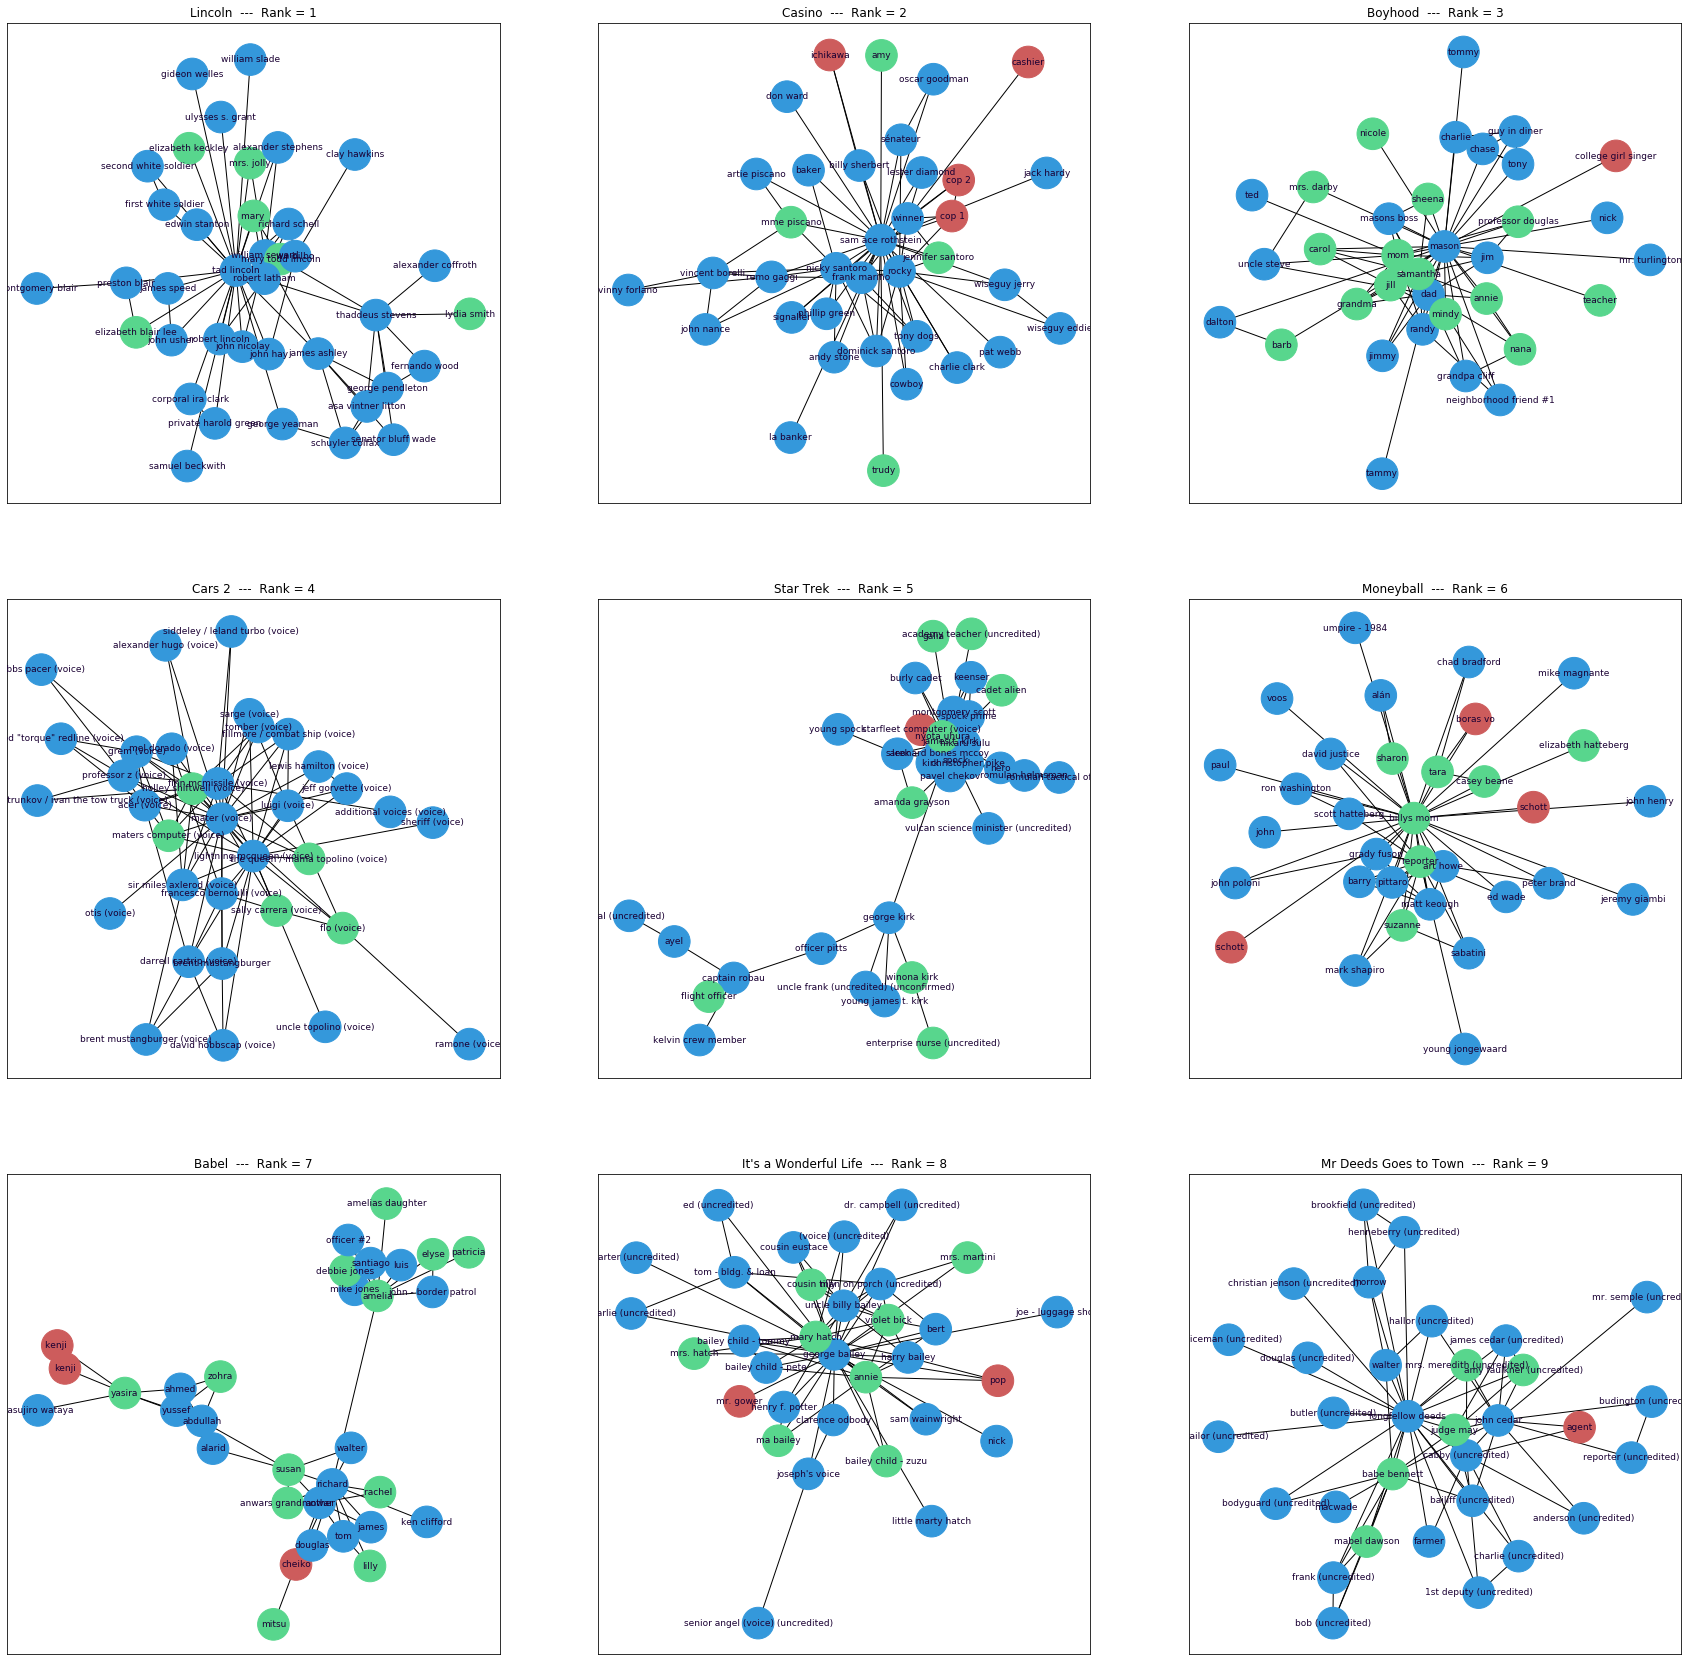

In [609]:
draw_islands(subgraph_dict[1])

Glancing at this, you see a lot of males in these.  Male dominated movies like Lincoln, Casino at the top.  You also see movies you wouldn't think being male dominated (Cars 2) still showing a lot of blue.  Let's look at the "tallest" islands.

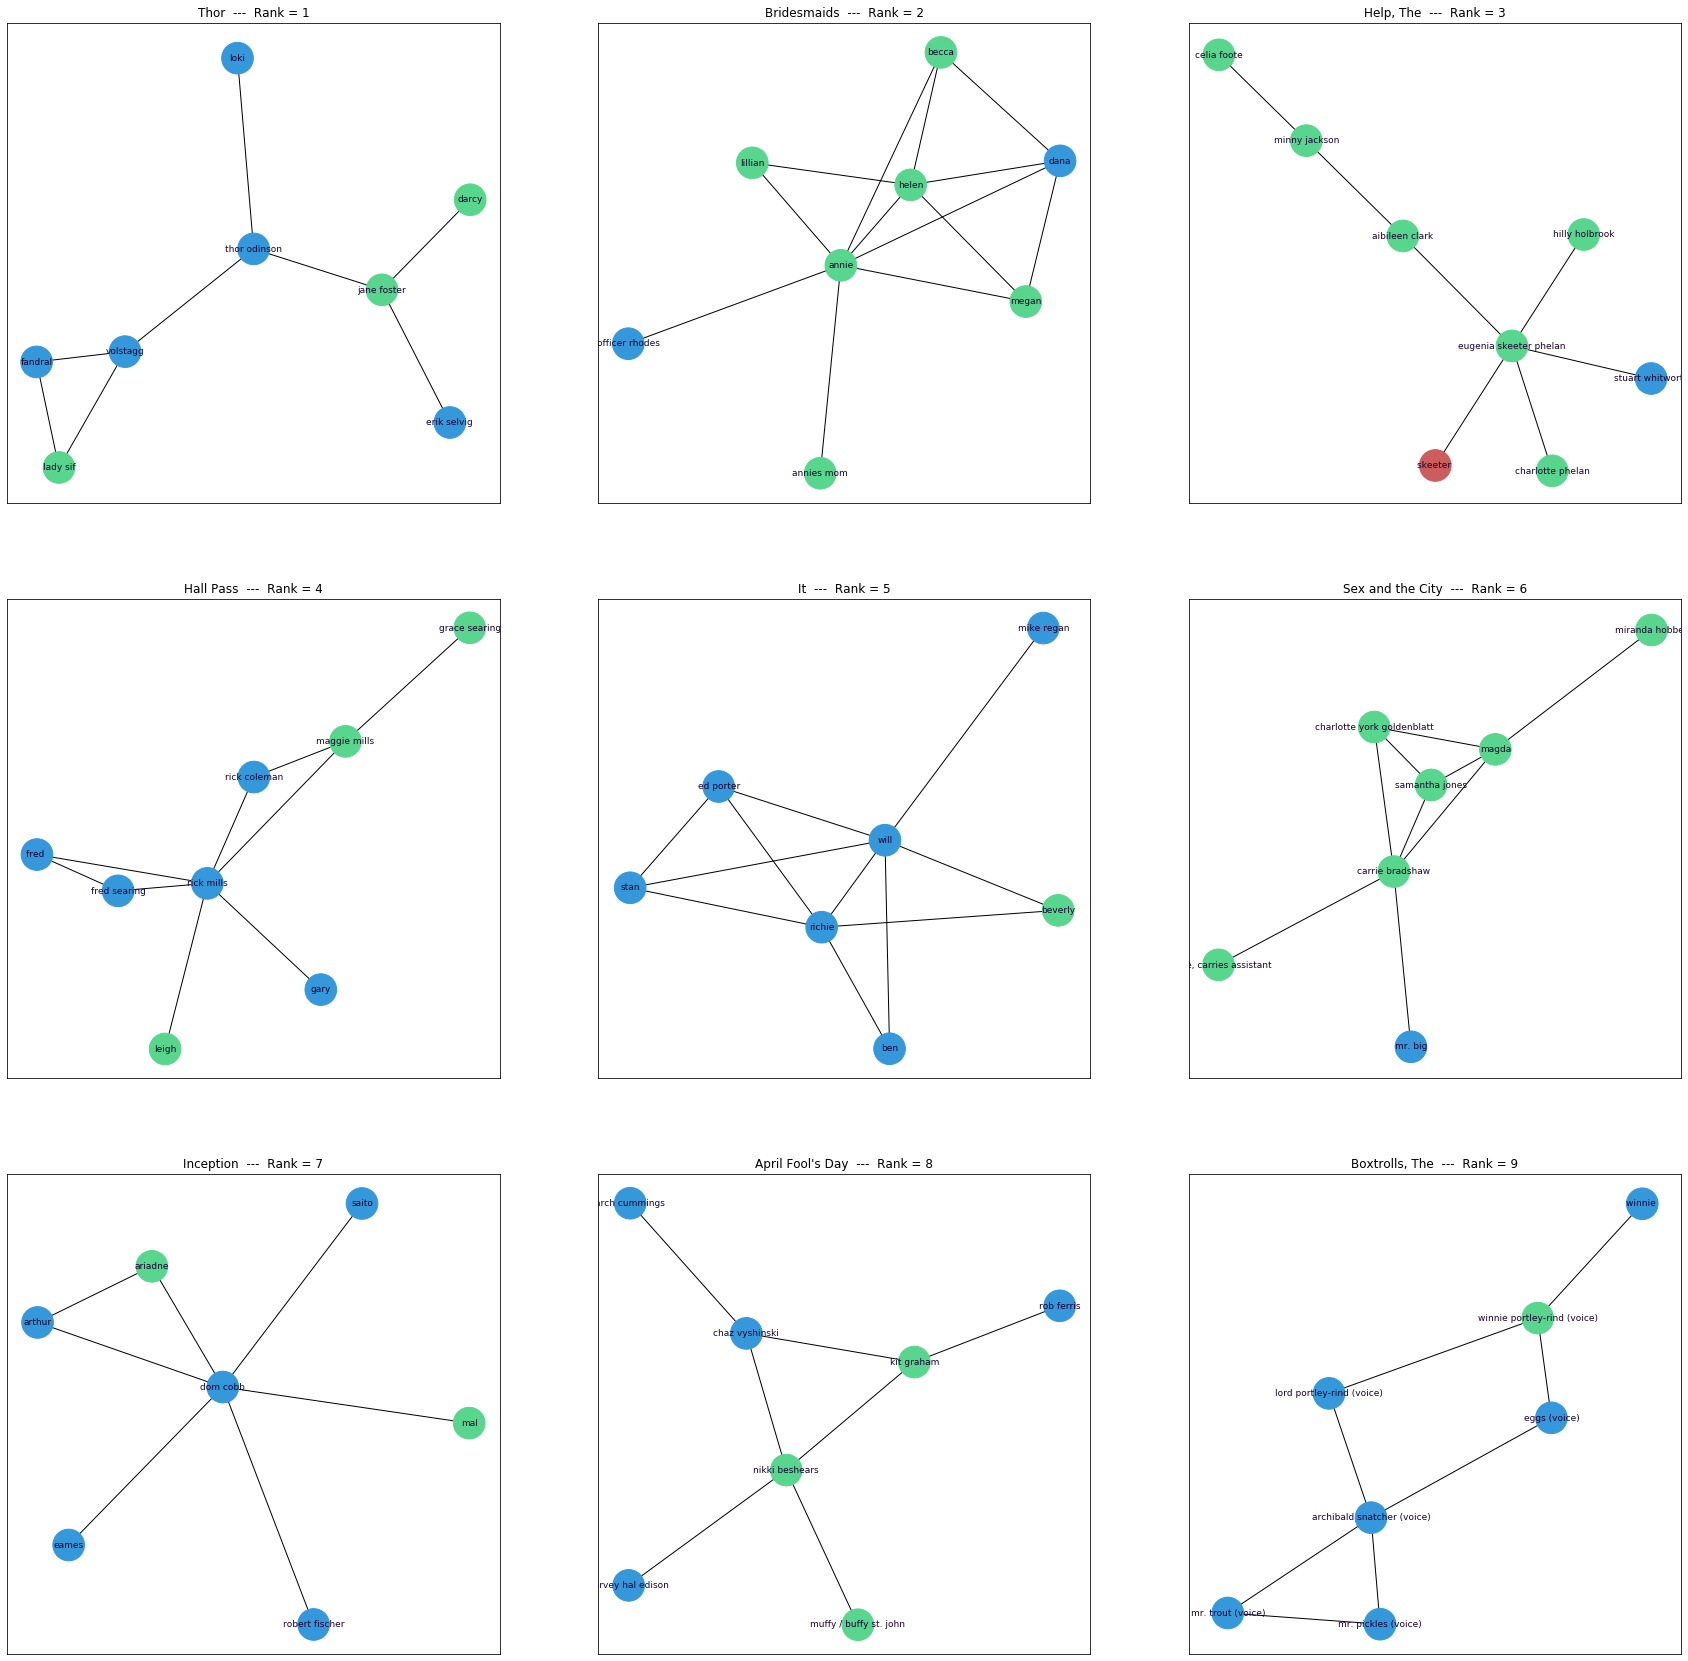

In [611]:
draw_islands(subgraph_dict[15])

Glancing through these, we see a lot more green. My hypothesis would be that Female-dominated movies tend to be smaller in scale, with a smaller number of characters.  Let's take a look at centrality measures.

In [627]:
measure_dict = {
    'degree': nx.degree_centrality,
    'closeness': nx.closeness_centrality,
    'betweenness': nx.betweenness_centrality,
    'eigenvector': nx.eigenvector_centrality
}
node_df = pd.DataFrame(list(M.nodes), columns = ['node_key'])
node_df[['title','female','character_name']] = node_df['node_key'].str.split('_', n=3, expand=True)
node_df.head()

,node_key,title,female,character_name
0,Deep Rising_0_vivo,Deep Rising,0,vivo
1,Up in the Air_0_bob,Up in the Air,0,bob
2,Braveheart_0_king edward,Braveheart,0,king edward
3,Army of Darkness_0_wiseman,Army of Darkness,0,wiseman
4,Predator_0_russian officer (uncredited),Predator,0,russian officer (uncredited)


In [633]:
for col_name, measure in measure_dict.items():
    m = measure(M)  
    node_df[col_name] =node_df['node_key'].map(m)

node_df.sort_values('degree', ascending=False).head(10)

,node_key,title,female,character_name,degree,closeness,betweenness,eigenvector
6276,Boyhood_0_mason,Boyhood,0,mason,0.002337,0.002339,4.124179e-06,1.332347e-07
9518,"Grapes of Wrath, The_1_mae","Grapes of Wrath, The",1,mae,0.002337,0.002337,1.950176e-07,1.944793e-01
11455,Casino_0_sam ace rothstein,Casino,0,sam ace rothstein,0.002337,0.002339,3.183730e-06,2.379789e-07
11304,"Grapes of Wrath, The_0_tim","Grapes of Wrath, The",0,tim,0.002337,0.002337,1.950176e-07,1.944793e-01
964,"Grapes of Wrath, The_0_pa joad","Grapes of Wrath, The",0,pa joad,0.002337,0.002337,1.950176e-07,1.944793e-01
1842,"Grapes of Wrath, The_0_joe","Grapes of Wrath, The",0,joe,0.002274,0.002275,1.400977e-07,1.934035e-01
11282,"Grapes of Wrath, The_0_al joad","Grapes of Wrath, The",0,al joad,0.002274,0.002275,1.732550e-07,1.917532e-01
3168,It's a Wonderful Life_0_george bailey,It's a Wonderful Life,0,george bailey,0.002274,0.002274,2.389890e-06,1.288920e-05
11945,"Grapes of Wrath, The_1_rosasharn","Grapes of Wrath, The",1,rosasharn,0.002147,0.002162,1.044395e-07,1.880631e-01
4155,"Grapes of Wrath, The_0_casy","Grapes of Wrath, The",0,casy,0.002084,0.002109,8.524000e-08,1.855444e-01


In [634]:
round(node_df.groupby('female').mean()*100000,3)

,degree,closeness,betweenness,eigenvector
female,,,,
-1,29.750,54.712,0.002,0.051
0,36.230,62.797,0.006,48.149
1,34.344,59.688,0.004,23.594


Does it really make sense to compute centrality measures for a bunch of graphs that are essentially separate? Well probably not, but it's interesting to look at nonetheless.  I had to multiply by 100k just to see the numbers, and betweenness is still tiny for all. This makes sense given what we're doing here - there are no edges between movies, so the betweenness measures are deflated. Interesting that while degree and closeness is pretty close for males vs. females, that Eigenvector is much higher for males. This would line up with my hypothesis - that males tend to be in large scale movies with lots of connections - females tend to be connected to fewer characters.

# Conclusions
Matching up character names is not easy, and is very time consuming. Figuring out better ways to do this matching would be a definite next step here, as there were some left on the table.

There is a ton that could be done here now that this dataset is in place. Looking at genres and seeing how the Female centrality measures within a movie relates to genre.  We have the dialogue, so we could use the dialogue to try to detect the character's gender. We could also try to predict their centrality based on the dialogue.  At the end of the day, we're just scratching the surface here, but the data is now in place for more analysis.
